# Procedure for estimating noise parameters

In [1]:
from __future__ import annotations

import numdifftools as nd
import numpy as np

from numpy.typing import ArrayLike
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from matplotlib.figure import figaspect
from scipy.optimize import approx_fprime
from numpy.random import default_rng

import thztools as thz
from thztools import tdnll

## Simulate measurements
Simulate a set of `m` waveforms, each sampled at `n` time points, with noise parameters
`sigma_alpha`, `sigma_beta`, and `sigma_tau`, and store them in an array `x`. Note that
`x` stores the waveforms in row orientation, with shape `(m, n)`, because NumPy
broadcasting rules and FFT functions are simpler for arrays that are row-oriented.
Measurement waveforms are typically loaded from data files in column orientation,
however, so the `tdnoisefit` function assumes that the data array is column-oriented—this
may be worth changing in a future version.

In [2]:
rng = np.random.default_rng(0)
n = 256
m = 64
ts = 0.05
t = np.arange(n) * ts
mu, _ = thz.thzgen(n, ts=ts, t0=n * ts / 3)
sigma = np.array([1e-5, 1e-2, 1e-3])
noise = thz.noiseamp(sigma, mu, ts) * rng.standard_normal((m, n))
x = np.array(mu + noise)
a = np.ones(m)
eta = np.zeros(m)

## Fit for the noise parameters

Set the initial guesses `a0` and `eta0` for the amplitudes and delays, respectively, and
estimate the noise parameters from the simulated measurements. Note that we must take the
transpose of `x`, to convert it from row-orientation to column-orientation.

In [3]:
result = thz.tdnoisefit(
    x.T, v0=sigma**2, mu0=mu, a0=a, eta0=eta, ts=ts, fix_v=True, fix_mu=False, fix_a=True, fix_eta=True
)

         Current function value: -147726.157845
         Iterations: 207
         Function evaluations: 605
         Gradient evaluations: 605


/Users/jsd/mambaforge/envs/thztools/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


## Plot the data

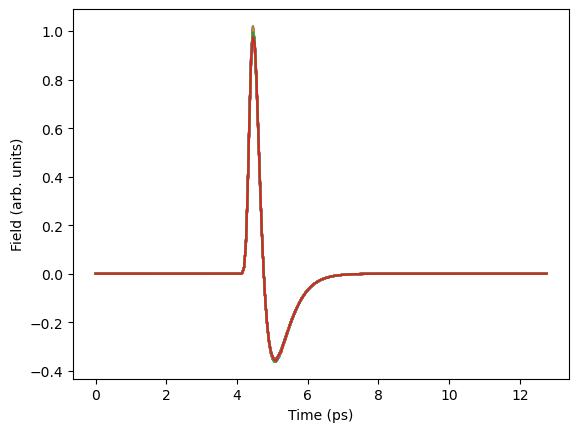

In [4]:
_, ax = plt.subplots()
ax.plot(t, x.T)
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Field (arb. units)')
plt.show()

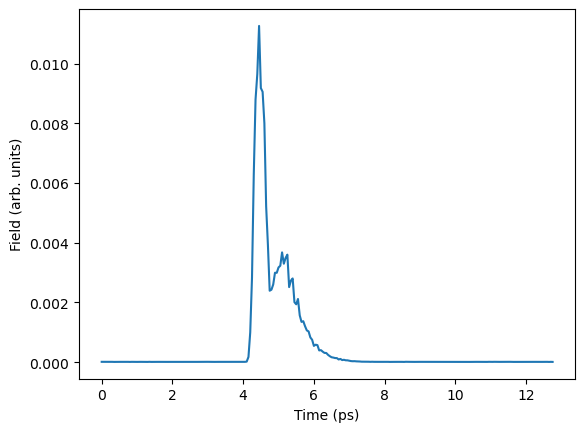

In [5]:
_, ax = plt.subplots()
ax.plot(t, np.std(x, axis=0).T)
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Field (arb. units)')
plt.show()

## Consider alternative method
Try alternating between minimizing the least-squares portion of the cost function for fixed $\sigma$ and minimizing the log-likelihood as a function of $\sigma$ while holding all other parameters fixed.

## Check gradient calculation in tdnll

In [6]:
logv = np.log(sigma**2)
val, grad_mu_tdnll = tdnll(x, mu, logv, a, eta, ts, fix_logv=True, fix_mu=False, fix_a=True, fix_eta=True)

In [7]:
grad_mu_fprime = approx_fprime(mu, lambda _mu: tdnll(x, _mu, logv, a, eta, ts, fix_logv=True, fix_mu=True, fix_a=True, fix_eta=True)[0], epsilon=1e-10)

In [8]:
grad_mu_tdnll

array([ 1.55708929e+06,  4.88661781e+05,  5.87287566e+05, -5.63994582e+05,
       -9.48484397e+05, -1.11423785e+06, -1.54137805e+06, -1.14154956e+06,
        2.91283579e+05, -3.42848351e+05,  8.32715288e+05, -5.84136730e+05,
       -1.09405807e+06, -5.36153270e+05, -1.79398811e+06, -1.65456739e+05,
        5.27988257e+05, -3.44634231e+04, -8.89878954e+05,  5.08611553e+05,
        5.55984833e+05, -8.85097218e+05, -1.38645450e+06,  2.99163478e+05,
       -1.41676123e+06,  2.08965975e+06,  1.40533874e+05,  1.05374326e+04,
       -6.32116569e+05, -3.35616675e+05,  6.08722390e+04, -7.67999494e+05,
        4.39766211e+05,  1.00697518e+06, -2.52042934e+05,  1.03071190e+05,
       -8.02639104e+05, -1.05235645e+06, -6.84200619e+05,  1.21247978e+06,
       -1.62849938e+05,  1.70708903e+05,  1.28508579e+06, -7.83626421e+05,
       -1.53949515e+06,  3.09969803e+05,  4.61465713e+04,  3.34672875e+05,
       -2.25447519e+05, -1.26245213e+06,  7.42530653e+04,  2.93740196e+04,
       -6.34052581e+05,  

In [9]:
grad_mu_fprime

array([ 1.55712129e+06,  4.88694641e+05,  5.87318500e+05, -5.63966169e+05,
       -9.48453962e+05, -1.11420726e+06, -1.54134672e+06, -1.14151539e+06,
        2.91314791e+05, -3.42817220e+05,  8.32749065e+05, -5.84102818e+05,
       -1.09402579e+06, -5.36123698e+05, -1.79395574e+06, -1.65425881e+05,
        5.28019445e+05, -3.44309956e+04, -8.89845833e+05,  5.08642697e+05,
        5.56017621e+05, -8.85063200e+05, -1.38642587e+06,  2.99195235e+05,
       -1.41673052e+06,  2.08968937e+06,  1.40568591e+05,  1.05687650e+04,
       -6.32086594e+05, -3.35586374e+05,  6.09035487e+04, -7.67966849e+05,
        4.39799333e+05,  1.00700650e+06, -2.52009777e+05,  1.03100610e+05,
       -8.02603900e+05, -1.05232350e+06, -6.84169936e+05,  1.21251156e+06,
       -1.62818178e+05,  1.70740532e+05,  1.28511630e+06, -7.83592986e+05,
       -1.53946370e+06,  3.09998286e+05,  4.61778836e+04,  3.34702490e+05,
       -2.25414697e+05, -1.26242405e+06,  7.42840348e+04,  2.94009806e+04,
       -6.34020253e+05,  

In [10]:
def tdnll_mu(_mu): return tdnll(x, _mu, logv, a, eta, ts, fix_logv=True, fix_mu=True, fix_a=True, fix_eta=True)[0]

In [11]:
grad_mu_nd = nd.Gradient(tdnll_mu, step=1e-10)(mu)

In [12]:
grad_mu_nd

array([ 1.55708929e+06,  4.88660403e+05,  5.87288475e+05, -5.63994353e+05,
       -9.48485753e+05, -1.11424049e+06, -1.54137919e+06, -1.14154862e+06,
        2.91282607e+05, -3.42848479e+05,  8.32714217e+05, -5.84137549e+05,
       -1.09405815e+06, -5.36151739e+05, -1.79398921e+06, -1.65458318e+05,
        5.27987533e+05, -3.44621338e+04, -8.89879374e+05,  5.08611514e+05,
        5.55986434e+05, -8.85095141e+05, -1.38645733e+06,  2.99163487e+05,
       -1.41676300e+06,  2.08965776e+06,  1.40534382e+05,  1.05376230e+04,
       -6.32116664e+05, -3.35616177e+05,  6.08700743e+04, -7.67999382e+05,
        4.39766554e+05,  1.00697251e+06, -2.52041916e+05,  1.03070334e+05,
       -8.02637011e+05, -1.05235775e+06, -6.84201603e+05,  1.21248032e+06,
       -1.62850033e+05,  1.70708649e+05,  1.28508637e+06, -7.83626536e+05,
       -1.53949617e+06,  3.09967992e+05,  4.61445559e+04,  3.34670448e+05,
       -2.25447129e+05, -1.26245421e+06,  7.42508503e+04,  2.93727474e+04,
       -6.34053815e+05,  

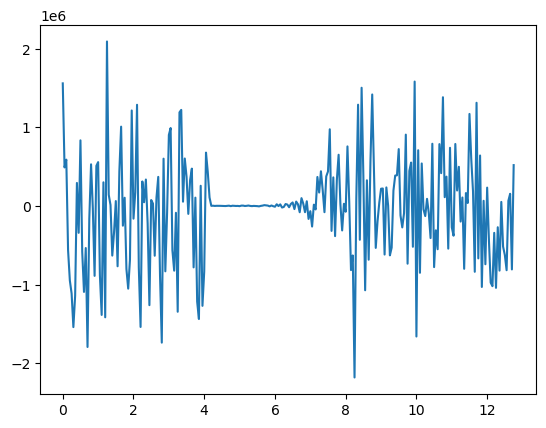

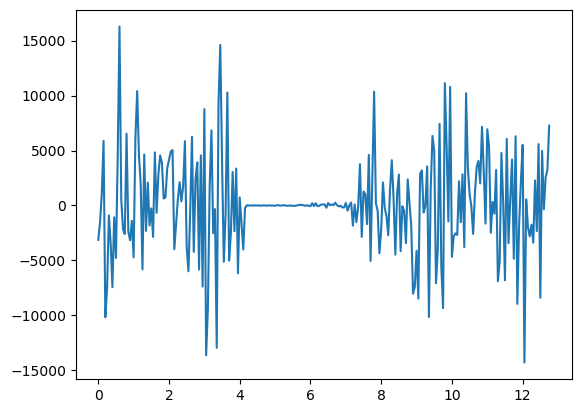

In [13]:
plt.plot(t, grad_mu_nd)
plt.show()
plt.plot(t, nd.Gradient(tdnll_mu, step=1e-10)(result[0]["mu"]))
plt.show()

In [14]:
result

({'var': array([1.e-10, 1.e-04, 1.e-06]),
  'mu': array([-2.36955001e-06, -8.35971874e-07, -8.44222884e-07,  8.16533882e-07,
          1.54229776e-06,  1.65120040e-06,  2.48688415e-06,  1.69611529e-06,
         -3.82349550e-07,  4.47670582e-07, -1.22033679e-06,  8.29545565e-07,
          1.82755284e-06,  7.43160133e-07,  2.89816452e-06,  1.53795366e-07,
         -7.12043314e-07, -5.51638999e-08,  1.49340103e-06, -9.07174174e-07,
         -7.63249422e-07,  1.27675547e-06,  2.30166449e-06, -5.82045060e-07,
          2.34130128e-06, -3.40166141e-06, -8.09716776e-08, -1.54800659e-07,
          1.12869889e-06,  3.79936987e-07,  4.95272649e-08,  1.04682991e-06,
         -5.27088127e-07, -1.73068842e-06,  5.58468686e-07, -3.18274402e-07,
          1.42900777e-06,  1.47168620e-06,  1.24842163e-06, -2.07219996e-06,
          4.49207790e-07, -4.53004122e-07, -1.80067810e-06,  1.01291886e-06,
          2.61441790e-06, -7.01198736e-07,  1.55491970e-07, -7.53596017e-07,
          5.93212688e-07,  1

In [15]:
val

-147612.11995440038

In [16]:
result2 = thz.tdnoisefit(
    x.T, v0=sigma**2, mu0=result[0]["mu"], a0=a, eta0=eta, ts=ts, fix_v=True, fix_mu=False, fix_a=True, fix_eta=True
)

         Current function value: -147726.162476
         Iterations: 109
         Function evaluations: 275
         Gradient evaluations: 263


/Users/jsd/mambaforge/envs/thztools/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


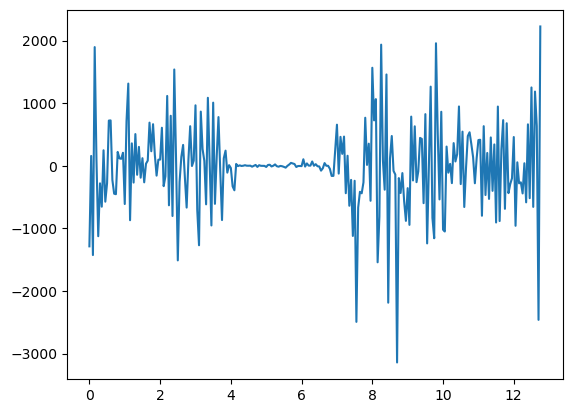

In [17]:
plt.plot(t, nd.Gradient(tdnll_mu, step=1e-10)(result2[0]["mu"]))
plt.show()

In [18]:
result3 = thz.tdnoisefit(
    x.T, v0=sigma**2, mu0=result2[0]["mu"], a0=a, eta0=eta, ts=ts, fix_v=True, fix_mu=False, fix_a=True, fix_eta=True
)

         Current function value: -147726.162822
         Iterations: 105
         Function evaluations: 199
         Gradient evaluations: 199


/Users/jsd/mambaforge/envs/thztools/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


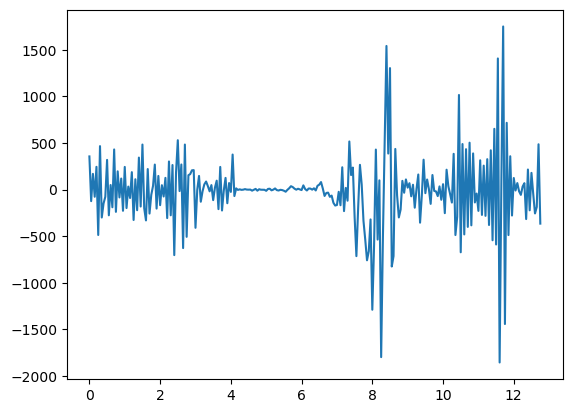

In [19]:
plt.plot(t, nd.Gradient(tdnll_mu, step=1e-10)(result3[0]["mu"]))
plt.show()

In [20]:
result4 = thz.tdnoisefit(
    x.T, v0=sigma**2, mu0=result3[0]["mu"], a0=a, eta0=eta, ts=ts, fix_v=True, fix_mu=False, fix_a=True, fix_eta=True
)

         Current function value: -147726.162957
         Iterations: 100
         Function evaluations: 193
         Gradient evaluations: 193


/Users/jsd/mambaforge/envs/thztools/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


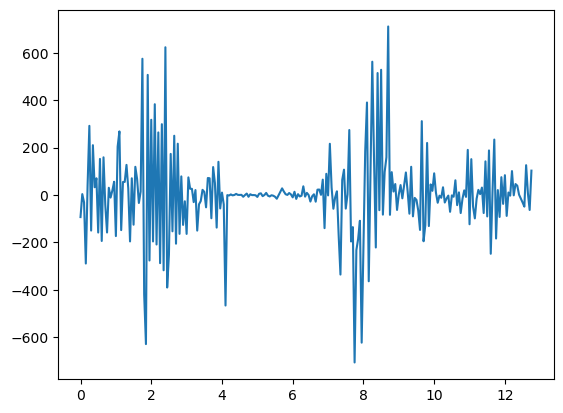

In [21]:
plt.plot(t, nd.Gradient(tdnll_mu, step=1e-10)(result4[0]["mu"]))
plt.show()

In [22]:
result5 = thz.tdnoisefit(
    x.T, v0=sigma**2, mu0=result4[0]["mu"], a0=a, eta0=eta, ts=ts, fix_v=True, fix_mu=False, fix_a=True, fix_eta=True
)

         Current function value: -147726.163018
         Iterations: 110
         Function evaluations: 213
         Gradient evaluations: 213


/Users/jsd/mambaforge/envs/thztools/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


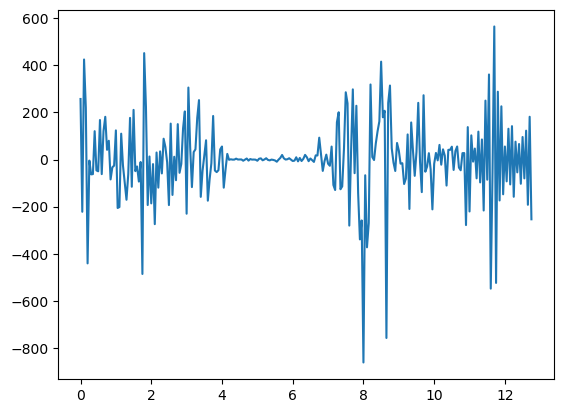

In [23]:
_, grad_mu = tdnll(x, result5[0]["mu"], logv, a, eta, ts, fix_logv=True, fix_mu=False, fix_a=True, fix_eta=True)
plt.plot(t, grad_mu)
plt.show()

In [24]:
result6 = thz.tdnoisefit(
    x.T, v0=sigma**2, mu0=result5[0]["mu"], a0=a, eta0=eta, ts=ts, fix_v=True, fix_mu=False, fix_a=True, fix_eta=True
)

         Current function value: -147726.163046
         Iterations: 100
         Function evaluations: 197
         Gradient evaluations: 197


/Users/jsd/mambaforge/envs/thztools/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


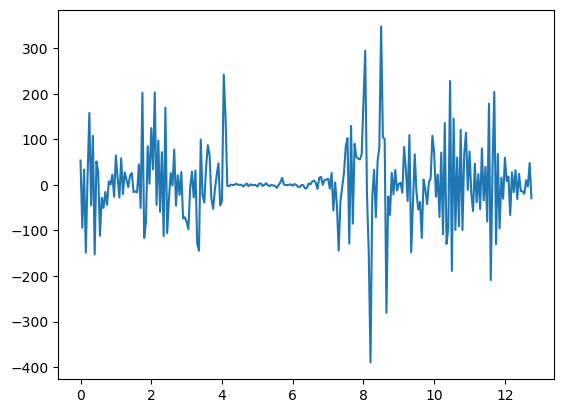

In [25]:
_, grad_mu = tdnll(x, result6[0]["mu"], logv, a, eta, ts, fix_logv=True, fix_mu=False, fix_a=True, fix_eta=True)
plt.plot(t, grad_mu)
plt.show()

In [26]:
result7 = thz.tdnoisefit(
    x.T, v0=sigma**2, mu0=result6[0]["mu"], a0=a, eta0=eta, ts=ts, fix_v=True, fix_mu=False, fix_a=True, fix_eta=True
)

         Current function value: -147726.163060
         Iterations: 105
         Function evaluations: 204
         Gradient evaluations: 204


/Users/jsd/mambaforge/envs/thztools/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


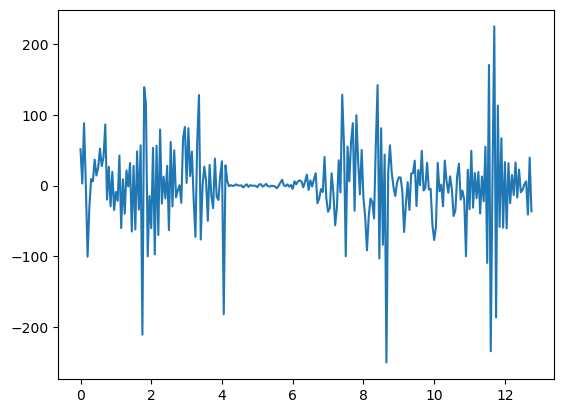

In [27]:
_, grad_mu = tdnll(x, result7[0]["mu"], logv, a, eta, ts, fix_logv=True, fix_mu=False, fix_a=True, fix_eta=True)
plt.plot(t, grad_mu)
plt.show()

         Current function value: -147726.163066
         Iterations: 84
         Function evaluations: 163
         Gradient evaluations: 163


/Users/jsd/mambaforge/envs/thztools/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


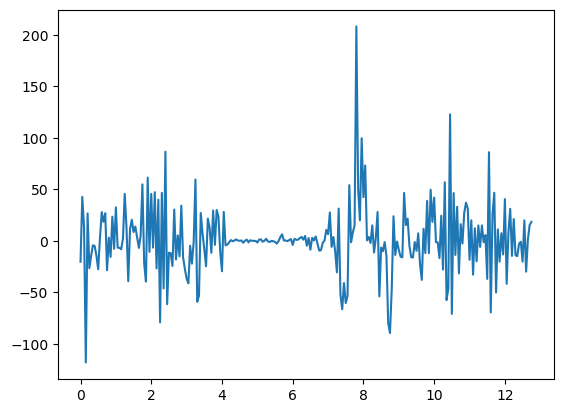

In [28]:
result8 = thz.tdnoisefit(
    x.T, v0=sigma**2, mu0=result7[0]["mu"], a0=a, eta0=eta, ts=ts, fix_v=True, fix_mu=False, fix_a=True, fix_eta=True
)
_, grad_mu = tdnll(x, result8[0]["mu"], logv, a, eta, ts, fix_logv=True, fix_mu=False, fix_a=True, fix_eta=True)
plt.plot(t, grad_mu)
plt.show()

         Current function value: -147726.163069
         Iterations: 93
         Function evaluations: 185
         Gradient evaluations: 185


/Users/jsd/mambaforge/envs/thztools/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


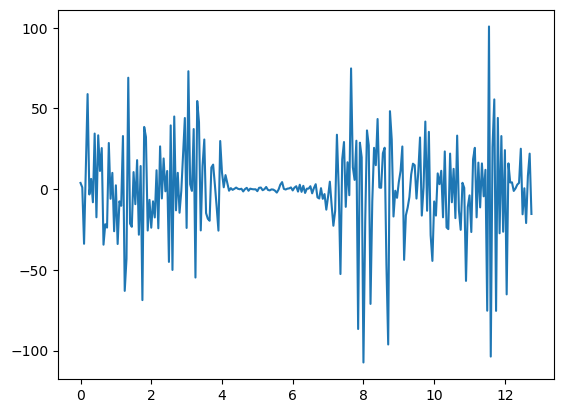

In [29]:
result9 = thz.tdnoisefit(
    x.T, v0=sigma**2, mu0=result8[0]["mu"], a0=a, eta0=eta, ts=ts, fix_v=True, fix_mu=False, fix_a=True, fix_eta=True
)
_, grad_mu = tdnll(x, result9[0]["mu"], logv, a, eta, ts, fix_logv=True, fix_mu=False, fix_a=True, fix_eta=True)
plt.plot(t, grad_mu)
plt.show()

         Current function value: -147726.163070
         Iterations: 84
         Function evaluations: 157
         Gradient evaluations: 157


/Users/jsd/mambaforge/envs/thztools/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


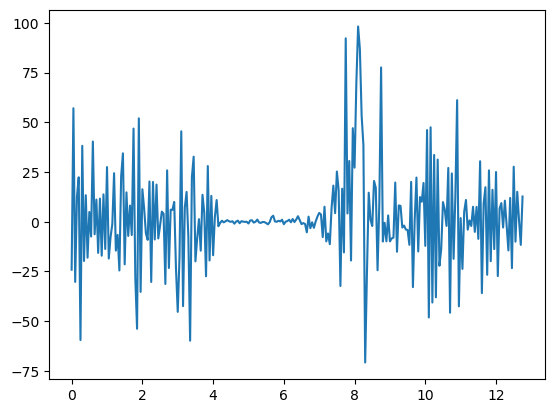

In [30]:
result10 = thz.tdnoisefit(
    x.T, v0=sigma**2, mu0=result9[0]["mu"], a0=a, eta0=eta, ts=ts, fix_v=True, fix_mu=False, fix_a=True, fix_eta=True
)
_, grad_mu = tdnll(x, result10[0]["mu"], logv, a, eta, ts, fix_logv=True, fix_mu=False, fix_a=True, fix_eta=True)
plt.plot(t, grad_mu)
plt.show()

         Current function value: -147726.163071
         Iterations: 90
         Function evaluations: 196
         Gradient evaluations: 184


/Users/jsd/mambaforge/envs/thztools/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


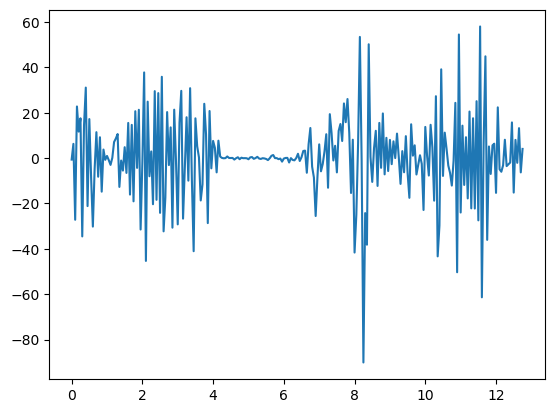

In [31]:
result11 = thz.tdnoisefit(
    x.T, v0=sigma**2, mu0=result10[0]["mu"], a0=a, eta0=eta, ts=ts, fix_v=True, fix_mu=False, fix_a=True, fix_eta=True
)
_, grad_mu = tdnll(x, result11[0]["mu"], logv, a, eta, ts, fix_logv=True, fix_mu=False, fix_a=True, fix_eta=True)
plt.plot(t, grad_mu)
plt.show()

         Current function value: -147726.163071
         Iterations: 75
         Function evaluations: 137
         Gradient evaluations: 137


/Users/jsd/mambaforge/envs/thztools/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


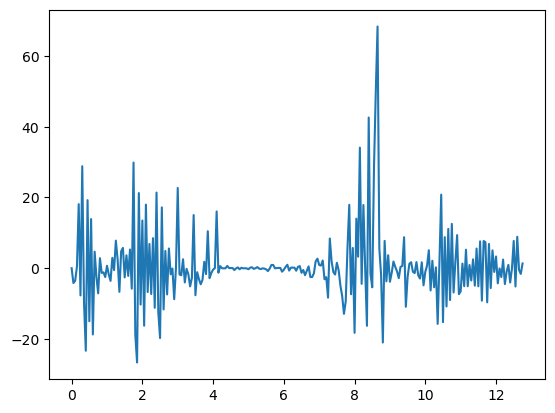

In [32]:
result12 = thz.tdnoisefit(
    x.T, v0=sigma**2, mu0=result11[0]["mu"], a0=a, eta0=eta, ts=ts, fix_v=True, fix_mu=False, fix_a=True, fix_eta=True
)
_, grad_mu = tdnll(x, result12[0]["mu"], logv, a, eta, ts, fix_logv=True, fix_mu=False, fix_a=True, fix_eta=True)
plt.plot(t, grad_mu)
plt.show()

         Current function value: -147726.163072
         Iterations: 93
         Function evaluations: 170
         Gradient evaluations: 170


/Users/jsd/mambaforge/envs/thztools/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


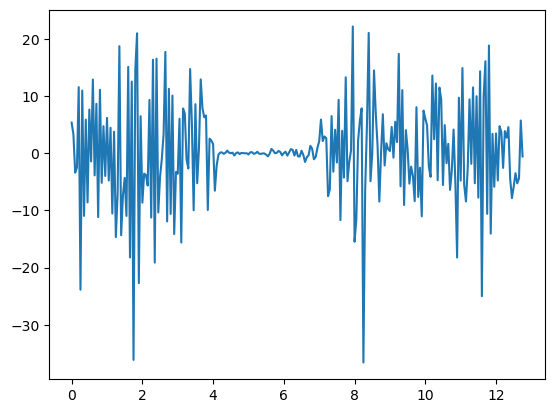

In [33]:
result13 = thz.tdnoisefit(
    x.T, v0=sigma**2, mu0=result12[0]["mu"], a0=a, eta0=eta, ts=ts, fix_v=True, fix_mu=False, fix_a=True, fix_eta=True
)
_, grad_mu = tdnll(x, result13[0]["mu"], logv, a, eta, ts, fix_logv=True, fix_mu=False, fix_a=True, fix_eta=True)
plt.plot(t, grad_mu)
plt.show()

         Current function value: -147726.163072
         Iterations: 48
         Function evaluations: 73
         Gradient evaluations: 73


/Users/jsd/mambaforge/envs/thztools/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


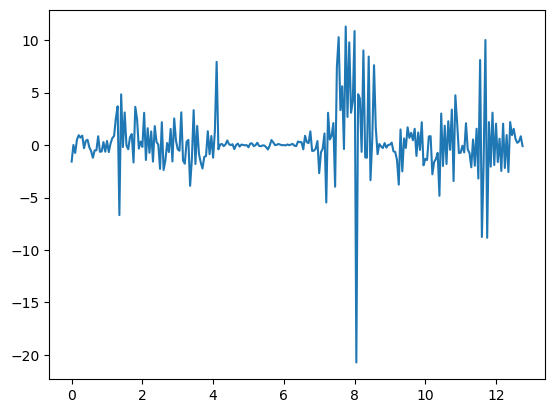

In [34]:
result14 = thz.tdnoisefit(
    x.T, v0=sigma**2, mu0=result13[0]["mu"], a0=a, eta0=eta, ts=ts, fix_v=True, fix_mu=False, fix_a=True, fix_eta=True
)
_, grad_mu = tdnll(x, result14[0]["mu"], logv, a, eta, ts, fix_logv=True, fix_mu=False, fix_a=True, fix_eta=True)
plt.plot(t, grad_mu)
plt.show()

         Current function value: -147726.163072
         Iterations: 12
         Function evaluations: 17
         Gradient evaluations: 17


/Users/jsd/mambaforge/envs/thztools/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


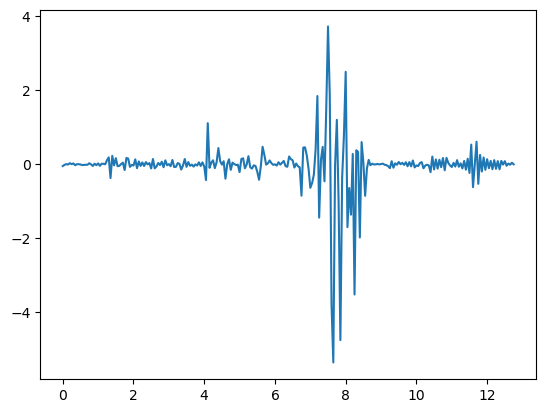

In [35]:
result15 = thz.tdnoisefit(
    x.T, v0=sigma**2, mu0=result14[0]["mu"], a0=a, eta0=eta, ts=ts, fix_v=True, fix_mu=False, fix_a=True, fix_eta=True
)
_, grad_mu = tdnll(x, result15[0]["mu"], logv, a, eta, ts, fix_logv=True, fix_mu=False, fix_a=True, fix_eta=True)
plt.plot(t, grad_mu)
plt.show()

         Current function value: -147726.163072
         Iterations: 4
         Function evaluations: 8
         Gradient evaluations: 8


/Users/jsd/mambaforge/envs/thztools/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


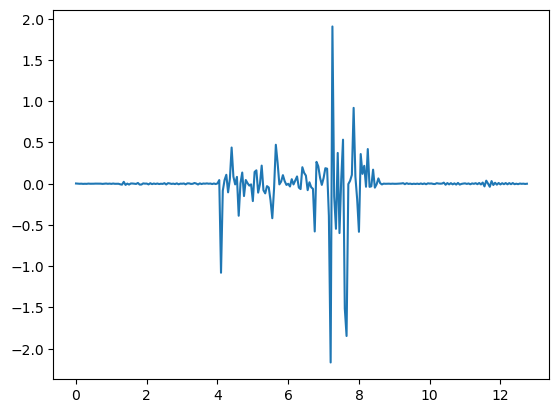

In [36]:
result16 = thz.tdnoisefit(
    x.T, v0=sigma**2, mu0=result15[0]["mu"], a0=a, eta0=eta, ts=ts, fix_v=True, fix_mu=False, fix_a=True, fix_eta=True
)
_, grad_mu = tdnll(x, result16[0]["mu"], logv, a, eta, ts, fix_logv=True, fix_mu=False, fix_a=True, fix_eta=True)
plt.plot(t, grad_mu)
plt.show()

         Current function value: -147726.163072
         Iterations: 3
         Function evaluations: 7
         Gradient evaluations: 7


/Users/jsd/mambaforge/envs/thztools/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


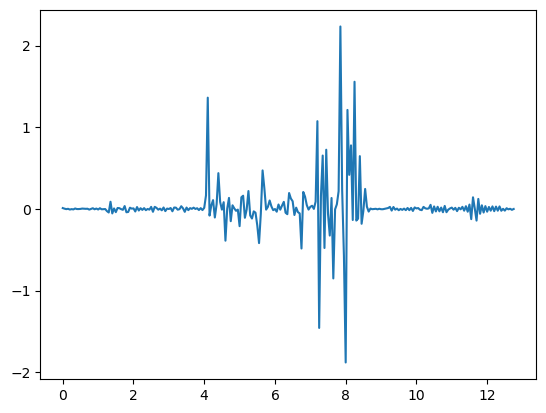

In [37]:
result17 = thz.tdnoisefit(
    x.T, v0=sigma**2, mu0=result16[0]["mu"], a0=a, eta0=eta, ts=ts, fix_v=True, fix_mu=False, fix_a=True, fix_eta=True
)
_, grad_mu = tdnll(x, result17[0]["mu"], logv, a, eta, ts, fix_logv=True, fix_mu=False, fix_a=True, fix_eta=True)
plt.plot(t, grad_mu)
plt.show()

         Current function value: -147726.163072
         Iterations: 1
         Function evaluations: 4
         Gradient evaluations: 4


/Users/jsd/mambaforge/envs/thztools/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


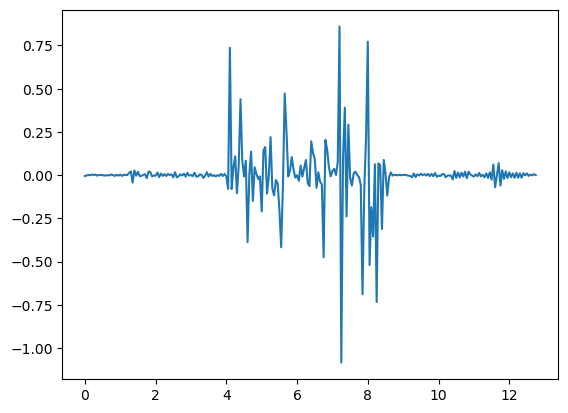

In [38]:
result18 = thz.tdnoisefit(
    x.T, v0=sigma**2, mu0=result17[0]["mu"], a0=a, eta0=eta, ts=ts, fix_v=True, fix_mu=False, fix_a=True, fix_eta=True
)
_, grad_mu = tdnll(x, result18[0]["mu"], logv, a, eta, ts, fix_logv=True, fix_mu=False, fix_a=True, fix_eta=True)
plt.plot(t, grad_mu)
plt.show()

/Users/jsd/mambaforge/envs/thztools/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -147726.163072
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5


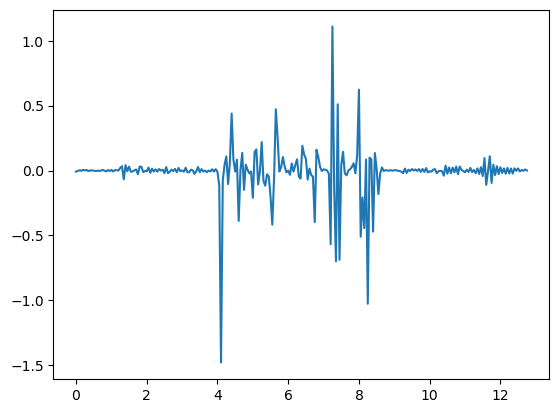

In [39]:
result19 = thz.tdnoisefit(
    x.T, v0=sigma**2, mu0=result18[0]["mu"], a0=a, eta0=eta, ts=ts, fix_v=True, fix_mu=False, fix_a=True, fix_eta=True
)
_, grad_mu = tdnll(x, result19[0]["mu"], logv, a, eta, ts, fix_logv=True, fix_mu=False, fix_a=True, fix_eta=True)
plt.plot(t, grad_mu)
plt.show()

/Users/jsd/mambaforge/envs/thztools/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -147726.163072
         Iterations: 2
         Function evaluations: 6
         Gradient evaluations: 6


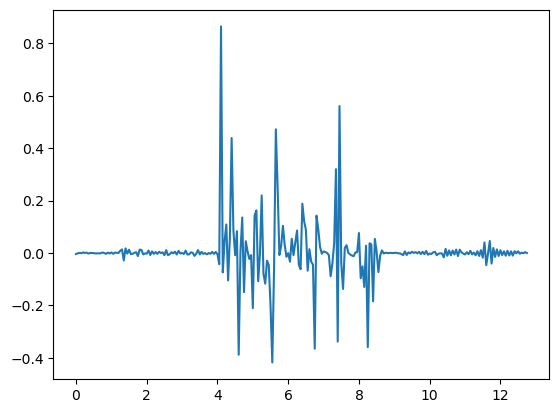

In [40]:
result20 = thz.tdnoisefit(
    x.T, v0=sigma**2, mu0=result19[0]["mu"], a0=a, eta0=eta, ts=ts, fix_v=True, fix_mu=False, fix_a=True, fix_eta=True
)
_, grad_mu = tdnll(x, result20[0]["mu"], logv, a, eta, ts, fix_logv=True, fix_mu=False, fix_a=True, fix_eta=True)
plt.plot(t, grad_mu)
plt.show()

         Current function value: -147726.163072
         Iterations: 1
         Function evaluations: 43
         Gradient evaluations: 31


/Users/jsd/mambaforge/envs/thztools/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


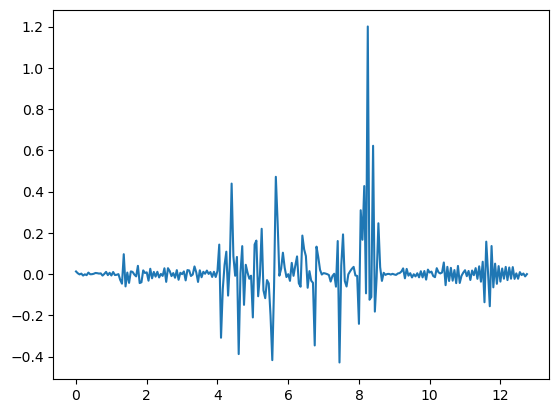

In [41]:
result21 = thz.tdnoisefit(
    x.T, v0=sigma**2, mu0=result20[0]["mu"], a0=a, eta0=eta, ts=ts, fix_v=True, fix_mu=False, fix_a=True, fix_eta=True
)
_, grad_mu = tdnll(x, result21[0]["mu"], logv, a, eta, ts, fix_logv=True, fix_mu=False, fix_a=True, fix_eta=True)
plt.plot(t, grad_mu)
plt.show()

/Users/jsd/mambaforge/envs/thztools/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -147726.163072
         Iterations: 0
         Function evaluations: 49
         Gradient evaluations: 37


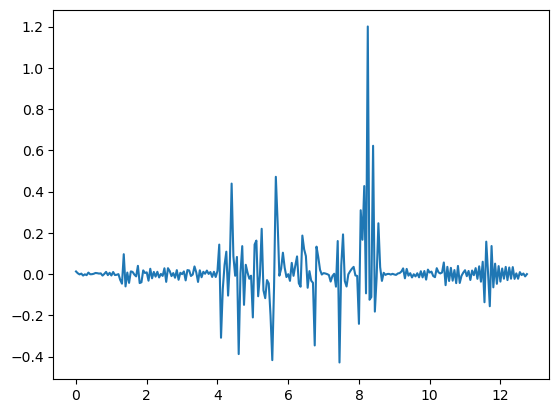

In [42]:
result22 = thz.tdnoisefit(
    x.T, v0=sigma**2, mu0=result21[0]["mu"], a0=a, eta0=eta, ts=ts, fix_v=True, fix_mu=False, fix_a=True, fix_eta=True
)
_, grad_mu = tdnll(x, result22[0]["mu"], logv, a, eta, ts, fix_logv=True, fix_mu=False, fix_a=True, fix_eta=True)
plt.plot(t, grad_mu)
plt.show()